## Extinction calculation

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.colors import LogNorm      
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from matplotlib import patches
import copy

from radmcutils import *

### Read in model

In [2]:
model = Radmc3dModel()
diry = '1jup30au/'
#diry='5jupcheck/checkrun/030/10jup50au/'
mass = 1
sep = 30
r = 0.03
model.read_grid(dir=diry)
model.read_file('dust_density.binp')
model.read_file('dust_temperature.bdat')
print(model.amrinfo)
nx, ny, nz = model.nx[0], model.ny[0], model.nz[0]

[[  0  35  34 311  60  34  60]
 [  1  31   4  31  60  62  60]
 [  2  31  20  31  60  86  60]
 [  3  31  44  31  60  86  60]]


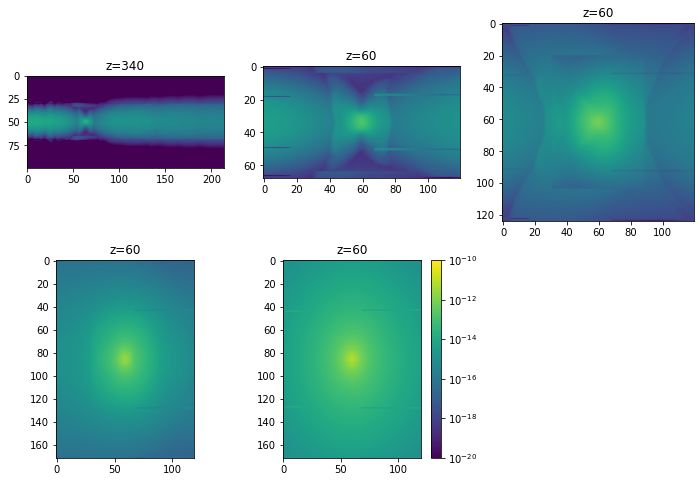

In [3]:
# ------- Plot density slices -------
cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))

plt.figure(figsize=(12,8))
for i in range(model.nrlayers):
    plt.subplot(2,3,i+1)
    zindex = int(model.nz[i]/2)
    plt.imshow(model.dust_dens[i][:,:,zindex].T,cmap=cmap, norm=LogNorm(vmin=1e-20,vmax=1e-10))
    plt.title("z="+str(zindex))
plt.colorbar()

### Define CPD and planet surface

In [4]:
# estimate Hill radius
from astropy.constants import *
import astropy.units as u
m = mass * M_jup   # planet mass
M = M_sun        # stellar mass
a = sep * u.AU      # planet orbital radius
r_hill = a * (m/(3*M))**(1/3)
print("Hill radius of planet is", r_hill)

Hill radius of planet is 2.048112329816627 AU


In [5]:
# conversion factor for each layer
xmin, xmax = (model.ix[0]*u.cm).to(u.AU), (model.ix[-1]*u.cm).to(u.AU)
ymin, ymax = model.iy[0], model.iy[-1]
AU2cellnr = [nx * 2**i / (xmax - xmin) for i in range(model.nrlayers)]
rad2cellnr = [ny * 2**i / (ymax - ymin) for i in range(model.nrlayers)]

# determine planet size and position
sizeau_pl =  r * r_hill  # radius of planet
x_pl = [int(AU2cellnr[0] * (a - xmin))] + [int(model.nx[i+1]/2) for i in range(model.nrlayers-1)]
y_pl = [int(model.ny[i]/2) for i in range(model.nrlayers)]
z_pl = [int(model.nz[i]/2) for i in range(model.nrlayers)]
print('planet coord for each layer:', x_pl, y_pl, z_pl)
print('planet radius is', sizeau_pl)

# determine CPD size
sizeau_CPD = (1/2) * r_hill  # radius of CPD is 0.5 r_hill
sizerad_CPD = np.arctan(0.5 * sizeau_CPD / a).value # half height of CPD is 0.25 r_hill
print('CPD radius is {}, CPD half height is {} rad'.format(sizeau_CPD, sizerad_CPD))

planet coord for each layer: [63, 60, 60, 60, 60] [50, 34, 62, 86, 86] [340, 60, 60, 60, 60]
planet radius is 0.061443369894498806 AU
CPD radius is 1.0240561649083135 AU, CPD half height is 0.017065945756418174 rad


"\nrec_CPD = patches.Rectangle((x_pl,y_pl),sizex_CPD*2**(i+1),sizey_CPD*2**(i+1),linewidth=0.2,edgecolor='r',facecolor='none', zorder=10)\ncir_pl = patches.Circle((x_pl+0.5,y_pl+0.5), size/2, linewidth=0.2,edgecolor='r',facecolor='none', zorder=10)\naxins.add_patch(cir_pl)\naxins.add_patch(rec_CPD)"

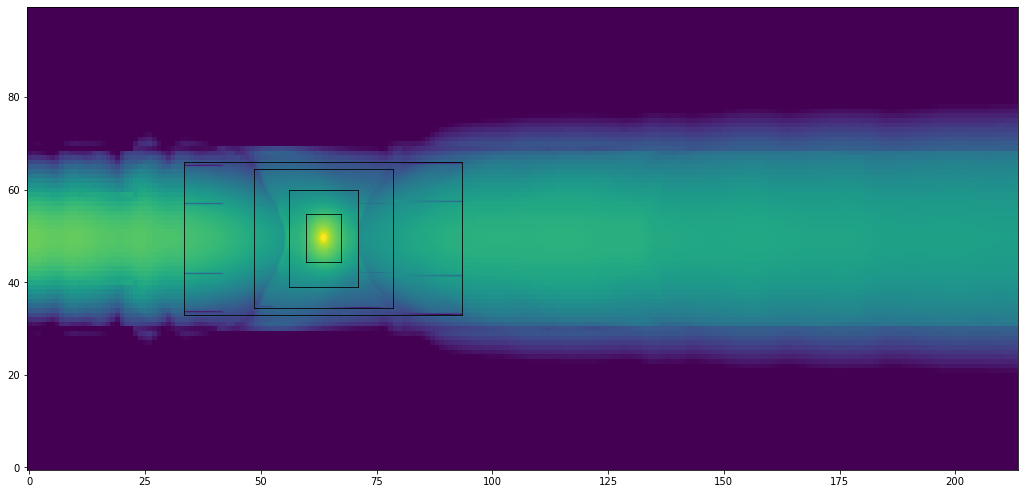

In [6]:
# plot all amr layers together
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def incl_amr(model, field, vmin=1e-20, vmax=1e-12, axis=True):
    # inset axes....
    for i in range(model.nrlayers-1):
        if i == 0:
            xmin = (model.amrinfo[0][1]-1)/nx 
            ymin = (model.amrinfo[0][2]-1)/ny
            xlen = model.amrinfo[0][4]/nx 
            ylen = model.amrinfo[0][5]/ny 
        else: 
            t1 = xlen * (model.amrinfo[i][1]-1)/(2*model.amrinfo[i-1][4])
            t2 = ylen * (model.amrinfo[i][2]-1)/(2*model.amrinfo[i-1][5])
            xmin += t1
            ymin += t2
            xlen *= model.amrinfo[i][4]/(model.amrinfo[i-1][4]*2)
            ylen *= model.amrinfo[i][5]/(model.amrinfo[i-1][5]*2)
        bound = [xmin, ymin, xlen, ylen]

        axins = ax.inset_axes(bound)
        extent = (0, model.amrinfo[i][4]*2, 0, model.amrinfo[i][5]*2)
        z = int(model.nz[i+1]/2)
        axins.imshow(field[i+1][:,:,z].T, extent=extent, origin="lower", 
                    norm=LogNorm(vmin=vmin, vmax=vmax))
        if axis == False:
            axins.axis('off')
        else:
            axins.xaxis.set_ticklabels([])
            axins.xaxis.set_ticks_position('none')
            axins.yaxis.set_ticklabels([])
            axins.yaxis.set_ticks_position('none')
            '''
        y_pl = model.ny[i+1]/2
        x_pl = model.nx[i+1]/2
        size = int(AU2cellnr[i+1] * size_pl)'''

# density plot
fig, ax = plt.subplots(figsize=[nx/15, ny/15], tight_layout={'pad':0})
z = int(model.nz[0]/2)
im = ax.imshow(model.dust_dens[0][:,:,z].T, origin="lower", norm=LogNorm(vmin=1e-20, vmax=1e-12))
#fig.colorbar(im, ax=ax)
incl_amr(model, field=model.dust_dens, axis=True)
'''
rec_CPD = patches.Rectangle((x_pl,y_pl),sizex_CPD*2**(i+1),sizey_CPD*2**(i+1),linewidth=0.2,edgecolor='r',facecolor='none', zorder=10)
cir_pl = patches.Circle((x_pl+0.5,y_pl+0.5), size/2, linewidth=0.2,edgecolor='r',facecolor='none', zorder=10)
axins.add_patch(cir_pl)
axins.add_patch(rec_CPD)'''

In [ ]:
# temperature plot
fig, ax = plt.subplots(figsize=[nx/15, ny/15], tight_layout={'pad':0})
im = ax.imshow(model3.dust_temp[0][:,:,341].T, origin="lower", norm=LogNorm(vmin=10, vmax=1e3))
#fig.colorbar(im, ax=ax)
incl_amr(model3, model3.dust_temp, vmin=10, vmax=1e3, axis=True)

In [7]:
# def func: mark planet and CPD region on density plot
def plot_region(model,field,viewaxis='z',showbound=True,vmin=1e-20,vmax=1e-10,axis=True):
    if viewaxis == 'z':
        fig, ax = plt.subplots(figsize=[nx/10, ny/10], tight_layout={'pad':0})
        y = int(model.nz[0]/2)
        ax.imshow(field[0][:,:,z].T, origin="lower", norm=LogNorm(vmin=vmin, vmax=vmax))
    elif viewaxis == 'y':
        fig, ax = plt.subplots(figsize=[nx/10, nz/10], tight_layout={'pad':0})
        y = int(model.ny[0]/2)
        ax.imshow(field[0][:,y,:].T, origin="lower", norm=LogNorm(vmin=vmin, vmax=vmax))

    for i in range(model.nrlayers-1):
        if i == 0:
            xmin = (model.amrinfo[0][1]-1)/nx 
            ymin = (model.amrinfo[0][2]-1)/ny
            zmin = (model.amrinfo[0][3]-1)/nz
            xlen = model.amrinfo[0][4]/nx 
            ylen = model.amrinfo[0][5]/ny
            zlen = model.amrinfo[0][6]/nz
        else: 
            t1 = xlen * (model.amrinfo[i][1]-1)/(2*model.amrinfo[i-1][4])
            t2 = ylen * (model.amrinfo[i][2]-1)/(2*model.amrinfo[i-1][5])
            t3 = zlen * (model.amrinfo[i][3]-1)/(2*model.amrinfo[i-1][6])
            xmin += t1
            ymin += t2
            zmin += t3
            xlen *= model.amrinfo[i][4]/(model.amrinfo[i-1][4]*2)
            ylen *= model.amrinfo[i][5]/(model.amrinfo[i-1][5]*2)
            zlen *= model.amrinfo[i][6]/(model.amrinfo[i-1][6]*2)

        r_pl = int(AU2cellnr[i+1] * sizeau_pl)
        r_CPD = int(AU2cellnr[i+1] * sizeau_CPD)
        h_CPD = int(rad2cellnr[i+1] * sizerad_CPD)

        if viewaxis == 'z':
            index = int(model.nz[i+1]/2)
            bound = [xmin, ymin, xlen, ylen]
            extent = (0, model.amrinfo[i][4]*2, 0, model.amrinfo[i][5]*2)
            axins = ax.inset_axes(bound)
            axins.imshow(field[i+1][:,:,index].T, extent=extent, origin="lower", 
                    norm=LogNorm(vmin=vmin, vmax=vmax))
            if showbound:
                CPD = patches.Rectangle((x_pl[i+1]-r_CPD, y_pl[i+1]-h_CPD),   # origin of rectangle
                                        r_CPD*2, h_CPD*2,                     # width, height of rectangle
                                        linewidth=1,edgecolor='r',facecolor='none', zorder=10)
                pl = patches.Circle((x_pl[i+1], y_pl[i+1]), r_pl,           # center, radius of circle
                                    linewidth=1,edgecolor='r',facecolor='none', zorder=10)
                axins.add_patch(pl)
                axins.add_patch(CPD)

        elif viewaxis == 'y':
            index = int(model.ny[i+1]/2)
            bound = [xmin, zmin, xlen, zlen]
            extent = (0, model.amrinfo[i][4]*2, 0, model.amrinfo[i][6]*2)
            axins = ax.inset_axes(bound)
            axins.imshow(field[i+1][:,index,:].T, extent=extent, origin="lower", 
                        norm=LogNorm(vmin=vmin, vmax=vmax))
            if showbound:
                CPD = patches.Circle((x_pl[i+1], z_pl[i+1]), r_CPD, 
                                    linewidth=1,edgecolor='r',facecolor='none', zorder=10)
                pl = patches.Circle((x_pl[i+1], z_pl[i+1]), r_pl,               # center, radius of circle
                                    linewidth=1,edgecolor='r',facecolor='none', zorder=10)
                axins.add_patch(pl)
                axins.add_patch(CPD)
        if axis == False:
            axins.axis('off')
        else:
            axins.xaxis.set_ticklabels([])
            axins.xaxis.set_ticks_position('none')
            axins.yaxis.set_ticklabels([])
            axins.yaxis.set_ticks_position('none')

In [ ]:
# density plot
plot_region(model, field=model.dust_temp, viewaxis='z',vmin=10,vmax=1e3)

### Cases for extinction value

In [8]:
# def func: set zero
def set_zero(bound, fieldname='dust_dens', model=model):
    '''sets field outside bound -> 0'''
    if fieldname == 'dust_dens':
        field = model.dust_dens
    elif fieldname == 'dust_temp':
        field = model.dust_temp
    fieldnew = []
    for i in range(model.nrlayers):
        fieldnew.append(np.zeros((field[i].shape)))
        if  type(bound) is tuple:
            r, h = int(AU2cellnr[i] * bound[0]), int(rad2cellnr[i] * bound[1])
            x0, y0, z0 = x_pl[i], y_pl[i], z_pl[i]
            for x in range(x0-r, x0+r+1):
                for z in range(z0-r, z0+r+1):
                    for y in range(y0-r, y0+r+1):
                        ''' crit: measures how far a coordinate in array is from the center. 
                                crit>=0: inside the boundary.
                                crit<0: outside the boundary.'''   
                        crit1 = r - ((x0-x)**2 + (z0-z)**2)**0.5
                        crit2 = h - abs(y0-y)
                        if crit1 >= 0 and crit2 >= 0:
                            try:
                                fieldnew[i][x,y,z] = field[i][x,y,z]
                            except: 
                                pass
        else:
            r = int(AU2cellnr[i] * bound)
            x0, y0, z0 = x_pl[i], y_pl[i], z_pl[i]
            for x in range(x0-r, x0+r+1):
                for y in range(y0-r, y0+r+1):
                    for z in range(z0-r, z0+r+1):
                        ''' crit: measures how far a coordinate in array is from the center. 
                                crit>=0: inside the sphere.
                                crit<0: outside the sphere.'''   
                        crit = r - ((x0-x)**2 + (y0-y)**2 + (z0-z)**2)**0.5
                        if (crit) >= 0: 
                            fieldnew[i][x,y,z] = field[i][x,y,z]
    return fieldnew

def set_zero2(bound, fieldname='dust_dens', model=model):
    '''sets density inside bound -> 0'''
    if fieldname == 'dust_dens':
        field = model.dust_dens
    elif fieldname == 'dust_temp':
        field = model.dust_temp
    fieldnew = copy.deepcopy(field)
    for i in range(model.nrlayers):
        fieldnew.append(np.zeros((field[i].shape)))
        if  type(bound) is tuple:
            r, h = int(AU2cellnr[i] * bound[0]), int(rad2cellnr[i] * bound[1])
            x0, y0, z0 = x_pl[i], y_pl[i], z_pl[i]
            for x in range(x0-r, x0+r+1):
                for z in range(z0-r, z0+r+1):
                    for y in range(y0-r, y0+r+1):
                        ''' crit: measures how far a coordinate in array is from the center. 
                                crit>=0: inside the boundary.
                                crit<0: outside the boundary.'''   
                        crit1 = r - ((x0-x)**2 + (z0-z)**2)**0.5
                        crit2 = h - abs(y0-y)
                        if crit1 >= 0 and crit2 >= 0:
                            try:
                                fieldnew[i][x,y,z] = 0
                            except: 
                                pass
        else:
            r = int(AU2cellnr[i] * bound)
            x0, y0, z0 = x_pl[i], y_pl[i], z_pl[i]
            for x in range(x0-r, x0+r+1):
                for y in range(y0-r, y0+r+1):
                    for z in range(z0-r, z0+r+1):
                        ''' crit: measures how far a coordinate in array is from the center. 
                                crit>=0: inside the sphere.
                                crit<0: outside the sphere.'''   
                        crit = r - ((x0-x)**2 + (y0-y)**2 + (z0-z)**2)**0.5
                        if (crit) >= 0: 
                            fieldnew[i][x,y,z] = field[i][x,y,z]
    return fieldnew

In [ ]:
# CASE 0 cut+plot: set dens+temp inside CPD to 0
dust_dens_0 = set_zero2((sizeau_CPD,sizerad_CPD),fieldname='dust_dens')
plot_region(model, field=dust_dens_0, viewaxis='z', axis=False)
plot_region(model, field=dust_dens_0, viewaxis='y', axis=False)
dust_temp_0 = set_zero2((sizeau_CPD,sizerad_CPD),fieldname='dust_temp')
plot_region(model, field=dust_temp_0, viewaxis='z', axis=False, vmin=10, vmax=1e3)
plot_region(model, field=dust_temp_0, viewaxis='y', axis=False, vmin=10, vmax=1e3)

In [ ]:
# CASE 1 cut+plot: set dens+temp outside CPD to 0 --> realistic extinction of CSD
dust_dens_1 = set_zero((sizeau_CPD,sizerad_CPD),fieldname='dust_dens')
plot_region(model, field=dust_dens_1, viewaxis='z', axis=False)
plot_region(model, field=dust_dens_1, viewaxis='y', axis=False)
dust_temp_1 = set_zero((sizeau_CPD,sizerad_CPD),fieldname='dust_temp')
plot_region(model, field=dust_temp_1, viewaxis='z', axis=False, vmin=10, vmax=1e3)
plot_region(model, field=dust_temp_1, viewaxis='y', axis=False, vmin=10, vmax=1e3)

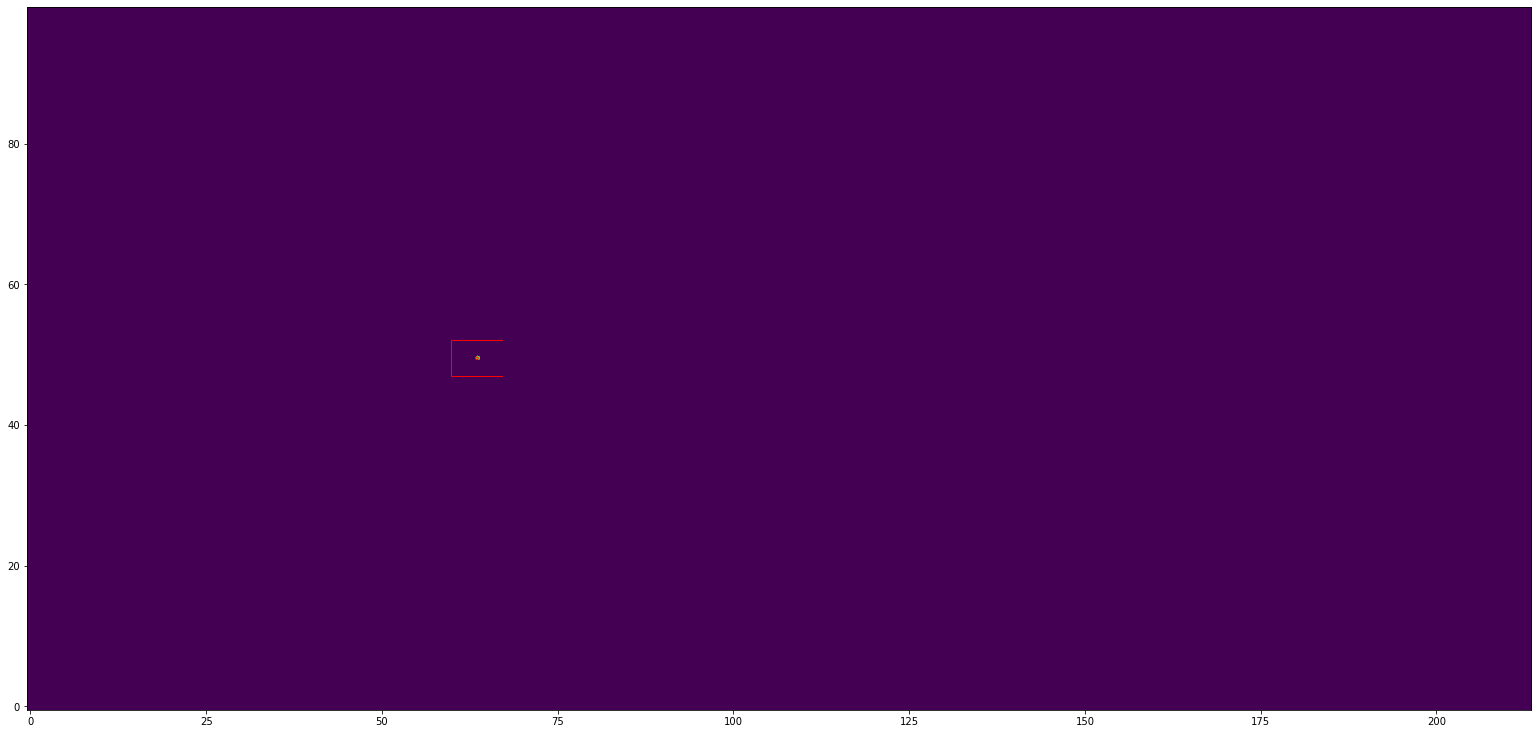

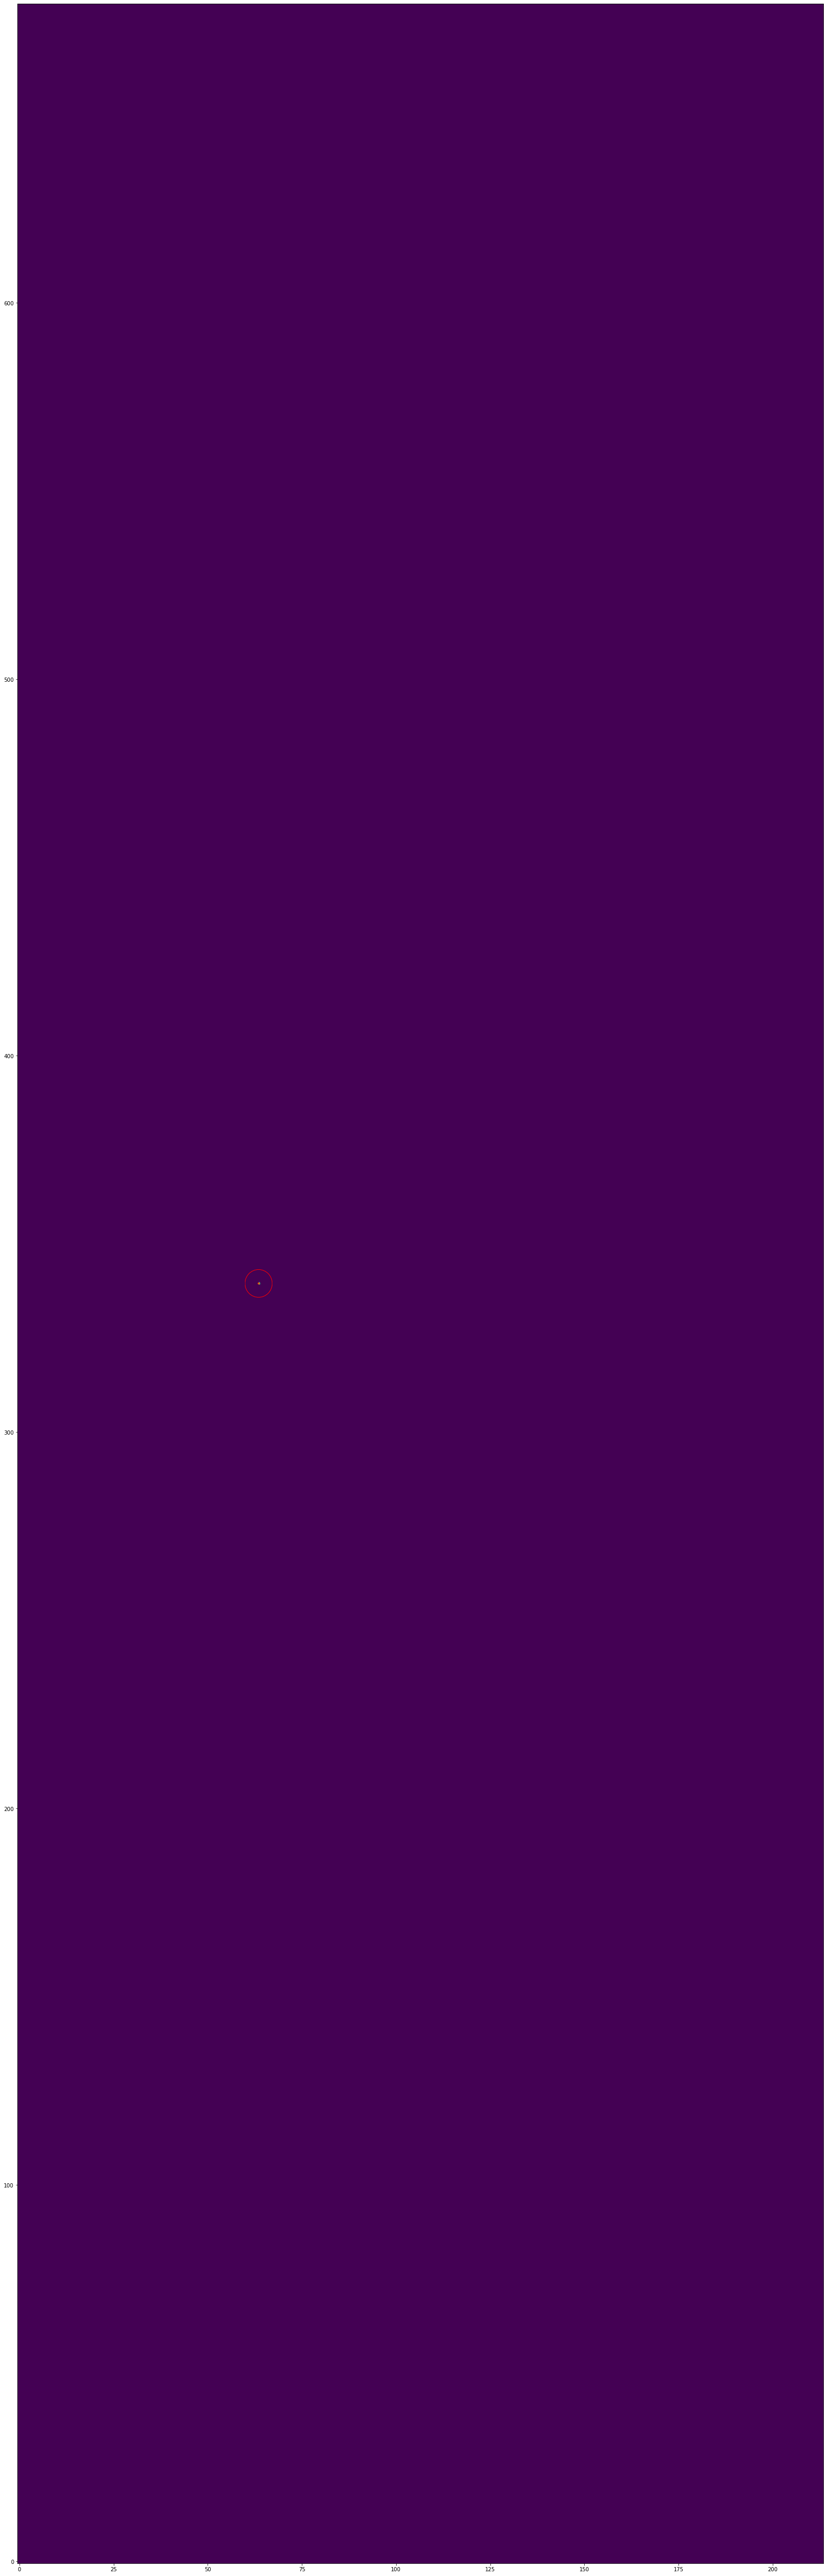

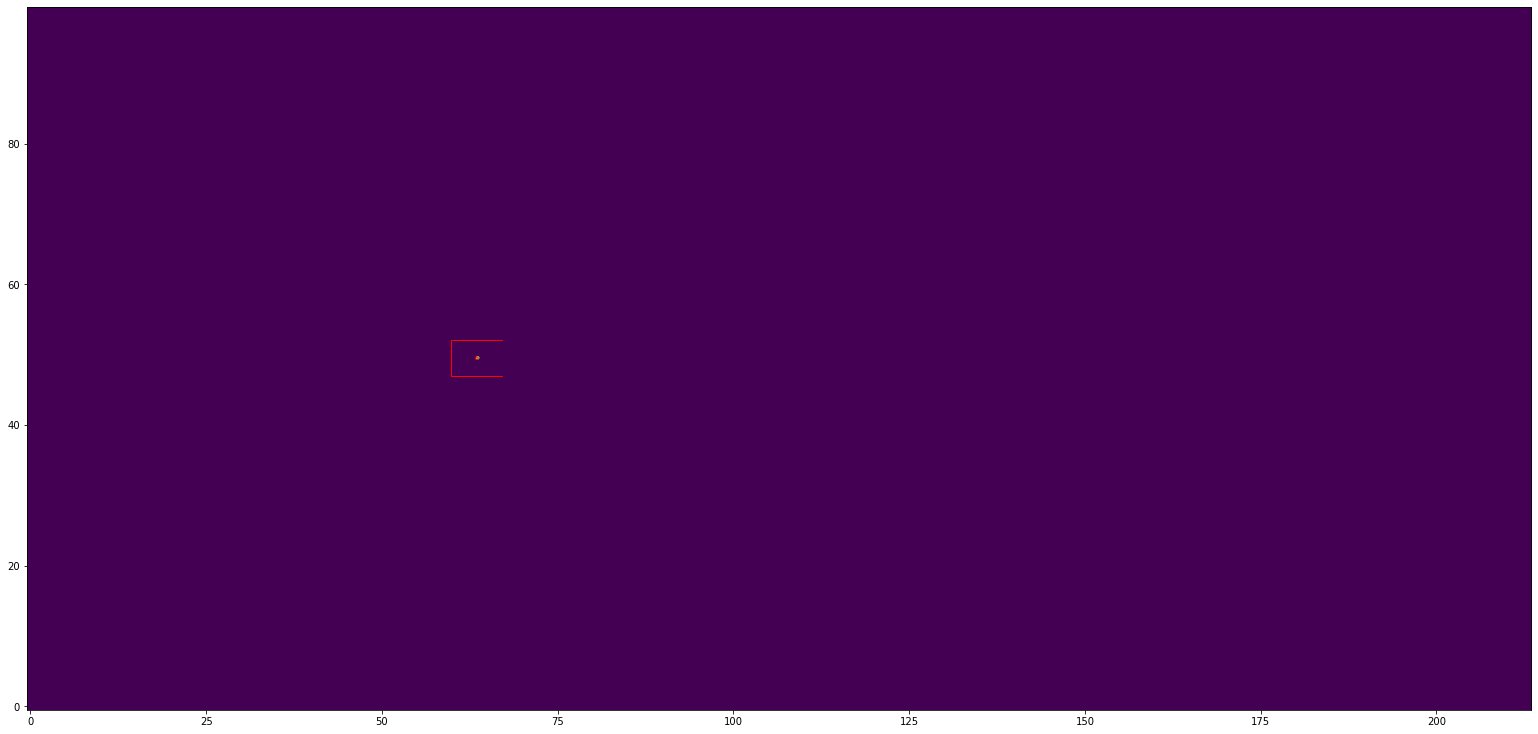

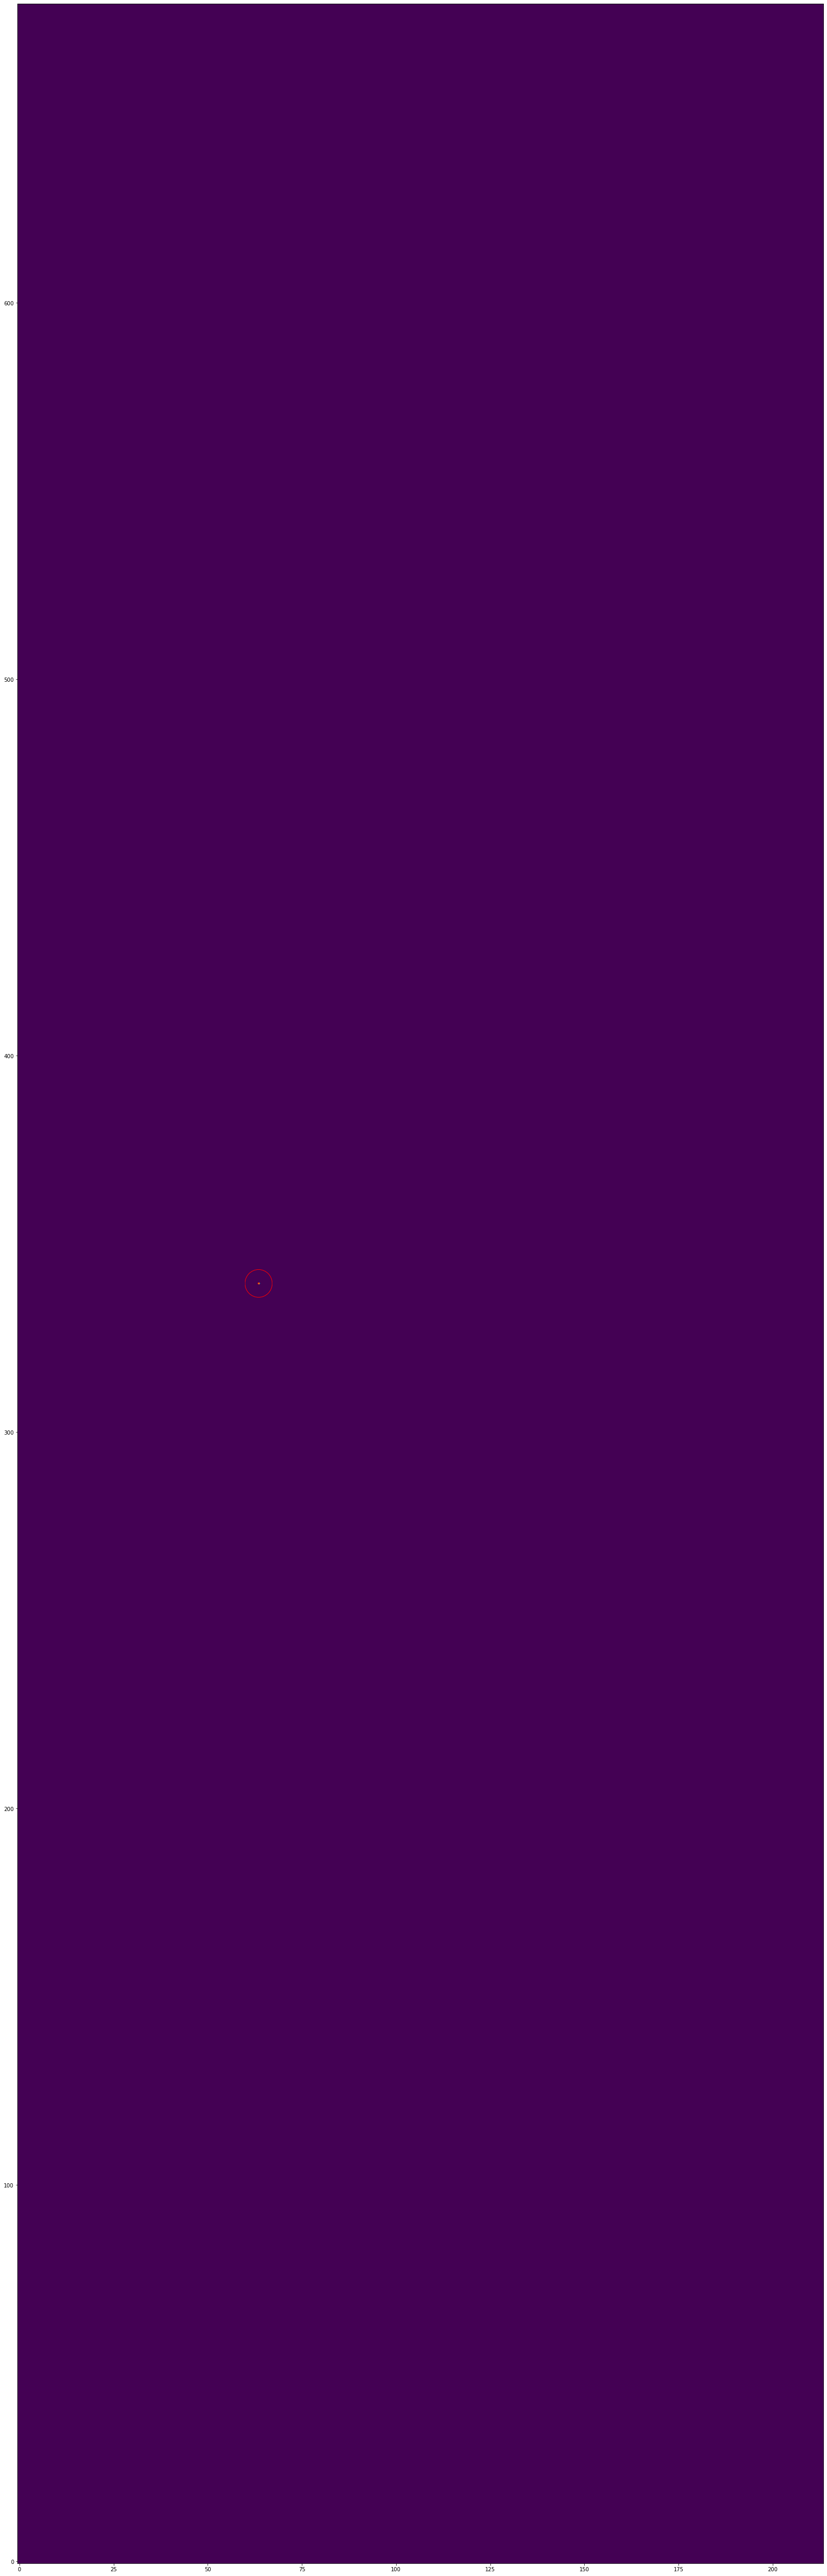

In [9]:
# CASE 2 cut+plot: set dens+temp outside planet surface to 0 --> realistic extinction of CSD + CPD
dust_dens_2 = set_zero(sizeau_pl,fieldname='dust_dens')
plot_region(model, field=dust_dens_2, viewaxis='z',axis=False)
plot_region(model, field=dust_dens_2, viewaxis='y',axis=False)
dust_temp_2 = set_zero(sizeau_pl,fieldname='dust_temp')
plot_region(model, field=dust_temp_2, viewaxis='z',axis=False, vmin=10, vmax=1e3)
plot_region(model, field=dust_temp_2, viewaxis='y',axis=False, vmin=10, vmax=1e3)

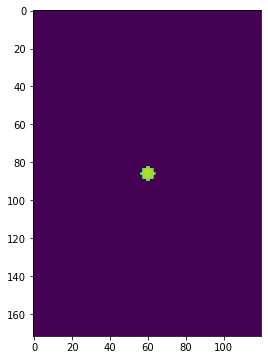

In [10]:
fig = plt.figure(figsize=(6,6))
plt.imshow(dust_dens_2[4][:,:,60].T,cmap=cmap, norm=LogNorm(vmin=1e-20,vmax=1e-10))

In [11]:
# CASE 2 write file
model.write_file(dust_dens_2, fname='dust_density.binp', dir='5jupcheck/checkrun/030/'+diry)
model.write_file(dust_temp_2, fname='dust_temperature.bdat', dir='5jupcheck/checkrun/030/'+diry)

In [ ]:
# CASE 0 write file
model.write_file(dust_dens_0, fname='dust_density_0.binp', dir='./')
model.write_file(dust_temp_0, fname='dust_temperature_0.bdat', dir='./')

In [ ]:
# CASE 1 write file
model.write_file(dust_dens_1, fname='dust_density_1.binp', dir='./')
model.write_file(dust_temp_1, fname='dust_temperature_1.bdat', dir='./')

In [ ]:
# CASE 3 write file: set temp outside CPD to 0 --> "perfect" extinction of CSD
model.write_file(dust_dens, fname='dust_density_3.binp', dir='./')
model.write_file(dust_temp_2, fname='dust_temperature_3.bdat', dir='./')

In [ ]:
# CASE 4 write file: set temp out planet surface to 0 + dens outside CPD to 0 --> "perfect" extinction of CSD + CPD
model.write_file(dust_dens_1, fname='dust_density_4.binp', dir='./')
model.write_file(dust_temp_2, fname='dust_temperature_4.bdat', dir='./')